In [1]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plts
import glob
from importlib import reload
from matplotlib import pyplot as plt

plt.rc('font', family='serif')
%matplotlib inline

In [2]:
# please update accordingly 
def load_spot_positions(skycam_unit, date):
    if skycam_unit == 1:
        if date == 'Jan25':
            s1 = 224, 1230 
            s3 = 739, 929 
            s4 = 736, 1530
            s5 = 738, 2132
            s6 = 1235, 1259
            s7 = 1255, 1832
            s8 = 1250, 2425
            s9 = 1773, 1539
            s10 = 1763, 2128
        elif date == 'Jan26':
            s1 = 244, 1214
            s3 = 760, 913
            s4 = 756, 1514
            s5 = 758, 2115
            s6 = 1277, 1216
            s7 = 1274, 1817
            s8 = 1268, 2407
            s9 = 1790, 1522
            s10 = 1780, 2110
       
        spot_positions = [s1, s3, s4, s5, s6, s7, s8, s9, s10]
       
    elif skycam_unit == 2:
        if date == 'Jan25':
            s1 = 589, 840 
            s2 = 583, 1438
            s3 = 585, 2048 
            s4 = 1114, 1137 
            s5 = 1115, 1747 
            s6 = 1104, 2353 
            s7 = 1641, 1442
        elif date == 'Jan26':
            s1 = 600, 588
            s2 = 592, 1177
            s3 = 594, 1785
            s4 = 1122, 877
            s5 = 1123, 1484
            s6 = 1120, 2087
            s7 = 1648, 1181
        
        spot_positions = [s1, s2, s3, s4, s5, s6, s7]
     
    return spot_positions

def invert_spots(spot_positions):
    spots_invert = []
    for spot in spot_positions:
        spots_invert.append((spot[1], spot[0]))
        
    return spots_invert

### Less manual way to do focus

In [16]:
# please change accordingly
focus_dir = 'skymonitor/KITTPEAK-Jan2020/focusing-skycam1/sdss-R/new/'

In [17]:
#all_files = glob.glob('sdss-R/new/*.FITS') # read focus images
all_files = glob.glob(focus_dir + '*.FITS')

focus_pos = []
micrometer_value = []

for f in all_files:
    focus_pos.append(fits.open(f)[0].data)
    micrometer_value.append(float(f.split('\\')[-1].split('mm.fits')[0]))

In [19]:
print(micrometer_value)

[0.0, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2.0, 2.25, 2.5, 2.75, 3.0, 3.25, 3.5, 3.75, 4.0]


In [6]:
spots = load_spot_positions(1, 'Jan25') # load spot positions that are determined beforehand

In [7]:
spots

[(224, 1230),
 (739, 929),
 (736, 1530),
 (738, 2132),
 (1235, 1259),
 (1255, 1832),
 (1250, 2425),
 (1773, 1539),
 (1763, 2128)]

In [8]:
# changing the spot position, if needed. 
spots[4] = 1260, 1235
spots[6] = 1250, 2430

In [20]:
# get the dispersion in the intensity counts for thumbnail images containing the fiber spots
std = []
nfocus, nspots = len(focus_pos), len(spots)
boxsize = 60 # thumbnail size in pixel unit

for i in range(nfocus*nspots):
    rowi = i // nfocus
    coli = i % nfocus
    cutout = focus_pos[coli][spots[rowi][0]-boxsize:spots[rowi][0]+boxsize, spots[rowi][1]-boxsize:spots[rowi][1]+boxsize]
    std.append(np.std(cutout.flatten()))

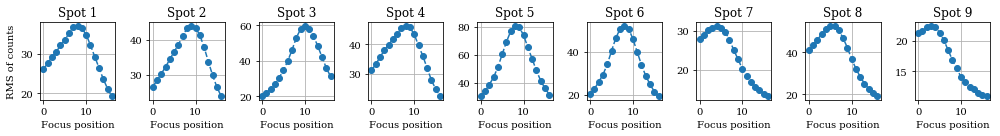

In [22]:
# plot the focus curves
std = np.array(std).reshape((nspots,nfocus))
bestfoc_idx = []

plt.figure(figsize=(14,2))
for i in range(len(std)):
    plt.subplot(1, nspots, i+1)
    bestfoc_idx.append(np.argmax(std[i]))
    plt.plot(std[i], 'o--')
    plt.title('Spot %d' % (i+1))
    
    plt.grid()
    if i == 0:
        plt.ylabel('RMS of counts')
    plt.xlabel('Focus position')
    
plt.tight_layout()
# plt.savefig('curve_sc1_rfilter.pdf')

In [23]:
bestfoc = np.array(micrometer_value)[bestfoc_idx] # best focus micrometer value for each spot
print(bestfoc) 
print("mean of bestfocus", np.mean(bestfoc))
print("rms of bestfocus", np.std(bestfoc))

[2.   2.25 2.5  2.   2.   2.   1.   1.5  0.75]
mean of bestfocus 1.7777777777777777
rms of bestfocus 0.5457467417885694


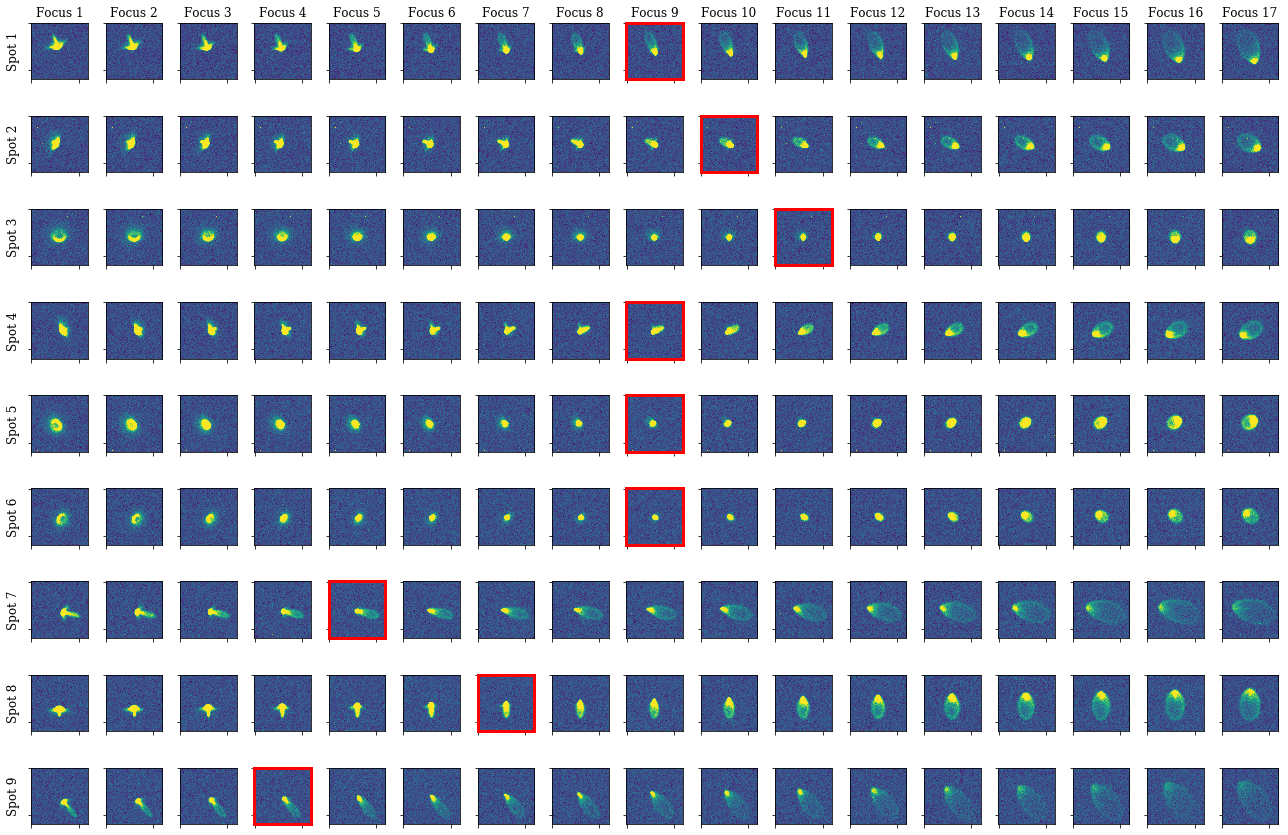

In [27]:
plt.figure(figsize=(18, 12))

for i in range(nfocus*nspots):
    rowi = i // nfocus
    coli = i % nfocus
    plt.subplot(nspots,nfocus,i+1)
    cutout = focus_pos[coli][spots[rowi][0]-boxsize:spots[rowi][0]+boxsize, spots[rowi][1]-boxsize:spots[rowi][1]+boxsize]
    plt.imshow(cutout, vmin=980, vmax=1115)
    plt.gca().set_xticklabels([])
    plt.gca().set_yticklabels([])
    
    if (i+1) in np.arange(1, nfocus*nspots, nfocus):
        plt.ylabel('Spot %d' % (rowi + 1), fontsize=12)
        
    if rowi == 0:
        plt.title('Focus %d' % (coli+1), fontsize=12)
       
    if coli == bestfoc_idx[rowi]:
        spines = ['top', 'bottom', 'right', 'left']
        for spine_i in spines:
            plt.gca().spines[spine_i].set_color('red')
            plt.gca().spines[spine_i].set_linewidth(3)

plt.tight_layout()
# plt.savefig('focus_sc1_rfilter.pdf')

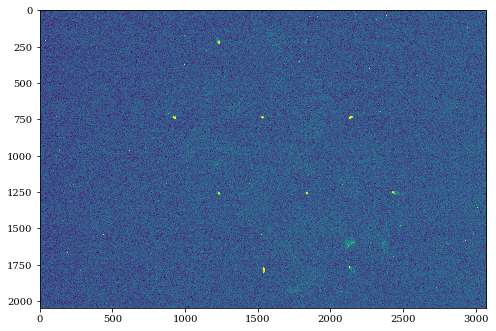

In [108]:
# plot entire image at best focus
plt.figure(figsize=(8,6))
plt.imshow(focus_pos[7], vmin=980, vmax=1100)
# plt.savefig('sc1_bestfocus.pdf')